In [284]:
from collections import defaultdict, Counter
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats

In [403]:
chroms = [str(x) for x in range(1, 23)]
#chroms = ['22']
family_sizes = [3, 4, 5, 6, 7]

wgs_phase_dir = '../phased_ihart'
chip_phase_dir = '../phased_ihart_23andme'

chip_positions_real_file = '../data/chip_positions.txt'
chip_positions_23andme_file = '../data/23andme_positions.txt'
chip_positions_ancestry_file = '../data/ancestry_positions.txt'
chip_positions_23andme_ancestry_file = '../data/23andme_ancestry_positions.txt'

In [404]:
ped_files = ['../data/160826.ped', '../data/ssc.ped']
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
fam_to_inds = dict()

for ped_file in ped_files:
    with open(ped_file, 'r') as f:
        for line in f:
            pieces = line.strip().split('\t')
            if len(pieces) >= 6:
                fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
                famkey = '.'.join((fam_id, m_id, f_id))
                if famkey not in fam_to_inds:
                    fam_to_inds[famkey] = [m_id, f_id]
                fam_to_inds[famkey].append(child_id)
                child_id_to_affected[child_id] = disease_status
                child_id_to_sex[child_id] = sex

In [405]:
# From GRCh37.p13 https://www.ncbi.nlm.nih.gov/grc/human/data?asm=GRCh37.p13
chrom_lengths = {
	'1': 249250621,
	'2': 243199373,
	'3': 198022430,
	'4': 191154276,
	'5': 180915260,
	'6': 171115067,
	'7': 159138663,
	'8': 146364022,
	'9': 141213431,
	'10': 135534747,
	'11': 135006516,
	'12': 133851895,
	'13': 115169878,
	'14': 107349540,
	'15': 102531392,
	'16': 90354753,
	'17': 81195210,
	'18': 78077248,
	'19': 59128983,
	'20': 63025520,
	'21': 48129895,
	'22': 51304566,
	'X': 155270560,
	'Y': 59373566
}
chrom_offsets = [0]
for chrom in chroms:
    chrom_offsets.append(chrom_offsets[-1]+chrom_lengths[chrom])
print(chrom_offsets)

[0, 249250621, 492449994, 690472424, 881626700, 1062541960, 1233657027, 1392795690, 1539159712, 1680373143, 1815907890, 1950914406, 2084766301, 2199936179, 2307285719, 2409817111, 2500171864, 2581367074, 2659444322, 2718573305, 2781598825, 2829728720, 2881033286]


# Filter Families


In [406]:
family_to_individuals = dict()

def load_families(phase_dir, family_sizes):
    family_to_chroms = defaultdict(set)
    
    for chrom in chroms:
        print(chrom, end=' ')

        for j in family_sizes:
            try:
                with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r') as f:
                    next(f) # skip header
                    for line in f:
                        pieces = line.strip().split('\t')
                        family_key = pieces[0]
                        family_to_chroms[family_key].add(chrom)
                        family_to_individuals[family_key] = pieces[1:(1+j)]
            except FileNotFoundError:
                print('File not found', 'chrom', chrom, 'family size', j)
            except StopIteration:
                print('File empty', 'chrom', chrom, 'family size', j)

    families_to_include = set([k for k, v in family_to_chroms.items() if len(v)==len(chroms)])
    print('Families with all chroms', len(families_to_include))
    print(Counter([len(v) for v in family_to_chroms.values()]))
    return families_to_include
    

In [407]:
families = load_families(wgs_phase_dir, family_sizes) & load_families(chip_phase_dir, family_sizes)
print('Families', len(families))

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 880
Counter({22: 880})
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 Families with all chroms 880
Counter({22: 880})
Families 880


In [408]:
individuals = sorted(sum([family_to_individuals[k] for k in families], []))
ind_to_index = dict([(x, i) for i, x in enumerate(individuals)])

# Read in deletions


In [409]:
# first, load positions
def find_deletion_positions(phase_dir):
    all_positions = []
    for chrom in chroms:
        print(chrom, end=' ')
        positions = set()
        for j in family_sizes:
            with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
                next(f) # skip header

                for line in f:
                    pieces = line.strip().split('\t')
                    family_key = pieces[0]
                    if family_key in families:
                        state = [int(x) for x in pieces[1:(2+(j*2))]]
                        start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]

                        if state[0]==0 or state[1]==0 or state[2]==0 or state[3]==0:
                            positions.add(start_pos-1)
                            positions.add(start_pos)
                            positions.add(end_pos)
                            positions.add(end_pos+1)

        all_positions.append(sorted(positions))
    return all_positions
        

In [410]:
# pull all positions on chip
def get_chip_positions(filename):
    chip_positions = []
    with open(filename, 'r') as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            chip_positions.append((pieces[1], int(pieces[2])))
    return chip_positions

chip_positions_real = get_chip_positions(chip_positions_real_file)
chip_positions_23andme = get_chip_positions(chip_positions_23andme_file)
chip_positions_ancestry = get_chip_positions(chip_positions_ancestry_file)
chip_positions_23andme_ancestry = get_chip_positions(chip_positions_23andme_ancestry_file)


In [411]:
wgs_positions = find_deletion_positions(wgs_phase_dir)
chip_positions = find_deletion_positions(chip_phase_dir)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [412]:
all_positions = []
for i, chrom in enumerate(chroms):
    all_positions.append(sorted(set(wgs_positions[i] + chip_positions[i] + \
                                    [x for c, x in chip_positions_real if c==chrom] + \
                                    [x for c, x in chip_positions_23andme if c==chrom] + \
                                    [x for c, x in chip_positions_ancestry if c==chrom] + \
                                    [x for c, x in chip_positions_23andme_ancestry if c==chrom])))
    print(chrom, len(all_positions[-1]))

1 166446
2 142471
3 119824
4 112620
5 101066
6 130615
7 105447
8 105912
9 119686
10 102827
11 100840
12 88274
13 58612
14 67396
15 62212
16 58525
17 62316
18 45438
19 55748
20 40911
21 29084
22 33032


In [413]:

# -1: unknown
# 0: no deletions (homref)
# 1: het deletion
# 2: homalt deletion
# 3: either 0 or 1
# 4: either 1 or 2
gen_to_code = {(-1, -1): -1,
                   (-1, 0): 4,
                   (-1, 1): 3,
                   (0, -1): 4,
                   (0, 0): 2,
                   (0, 1): 1,
                   (1, -1): 3,
                   (1, 0): 1,
                   (1, 1): 0
                  }

wgs_deletions = [np.zeros((len(individuals), len(all_positions[i])), dtype=np.int8) for i in range(len(chroms))]
chip_deletions = [np.zeros((len(individuals), len(all_positions[i])), dtype=np.int8) for i in range(len(chroms))]

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    position_to_index = dict([(x, i) for i, x in enumerate(all_positions[i])])

    for j in family_sizes:
        with open('%s/chr.%s.familysize.%d.phased.txt' % (wgs_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    inds = family_to_individuals[family_key]
                    indices = [ind_to_index[x] for x in inds]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    
                    if state[0]==0 or state[1]==0 or state[2]==0 or state[3]==0:
                        start_index = position_to_index[start_pos]
                        end_index = position_to_index[end_pos+1]
                        
                        # mom
                        if state[0] == 0 and state[1] == 0:
                            pass
                        else:
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                state[0] = -1
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                state[1] = -1
                        wgs_deletions[i][indices[0], start_index:end_index] = gen_to_code[(state[0], state[1])]

                        # dad
                        if state[2] == 0 and state[3] == 0:
                            pass
                        else:
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                state[2] = -1
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                state[3] = -1
                        wgs_deletions[i][indices[1], start_index:end_index] = gen_to_code[(state[2], state[3])]

                        # children
                        for k in range(2, j):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]
                            if mom_s == -1:
                                mom_gen = -1
                            else:
                                mom_gen = state[mom_s]
                            if dad_s == -1:
                                dad_gen = -1
                            else:
                                dad_gen = state[2+dad_s]
                            wgs_deletions[i][indices[k], start_index:end_index] = gen_to_code[(mom_gen, dad_gen)]

        with open('%s/chr.%s.familysize.%d.phased.txt' % (chip_phase_dir, chrom, j), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                family_key = pieces[0]
                if family_key in families:
                    inds = family_to_individuals[family_key]
                    indices = [ind_to_index[x] for x in inds]
                    state = [int(x) for x in pieces[1:(2+(j*2))]]
                    start_pos, end_pos = [int(x) for x in pieces[(2+(j*2)):(4+(j*2))]]
                    
                    if state[0]==0 or state[1]==0 or state[2]==0 or state[3]==0:
                        start_index = position_to_index[start_pos]
                        end_index = position_to_index[end_pos+1]
                        
                        # mom
                        if state[0] == 0 and state[1] == 0:
                            pass
                        else:
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==0]) == 0:
                                state[0] = -1
                            if len([i for i in range(4, len(state)-1, 2) if state[i]==1]) == 0:
                                state[1] = -1
                        chip_deletions[i][indices[0], start_index:end_index] = gen_to_code[(state[0], state[1])]

                        # dad
                        if state[2] == 0 and state[3] == 0:
                            pass
                        else:
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==0]) == 0:
                                state[2] = -1
                            if len([i for i in range(5, len(state)-1, 2) if state[i]==1]) == 0:
                                state[3] = -1
                        chip_deletions[i][indices[1], start_index:end_index] = gen_to_code[(state[2], state[3])]

                        # children
                        for k in range(2, j):
                            mom_s, dad_s = state[(2*k):(2*(k+1))]
                            if mom_s == -1:
                                mom_gen = -1
                            else:
                                mom_gen = state[mom_s]
                            if dad_s == -1:
                                dad_gen = -1
                            else:
                                dad_gen = state[2+dad_s]
                            chip_deletions[i][indices[k], start_index:end_index] = gen_to_code[(mom_gen, dad_gen)]

                

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

# Compare chip sites

In [414]:
if chip_phase_dir == '../phased_ihart_chip':
    sites = chip_positions_real
elif chip_phase_dir == '../phased_ihart_23andme':
    sites = chip_positions_23andme
elif chip_phase_dir == '../phased_ihart_ancestry':
    sites = chip_positions_ancestry
elif chip_phase_dir == '../phased_ihart_23andme_ancestry':
    sites = chip_positions_23andme_ancestry

In [415]:
# focus on parental calls
parent_indices = np.array([ind_to_index[x] for x in set(sum([family_to_individuals[famkey][:2] for famkey in families], []))])
child_indices = np.array(list(set(range(len(individuals))) - set(parent_indices)))

wgs_calls = []
chip_calls = []

wgs_calls_children = []
chip_calls_children = []

positions = []
for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    pos_to_index = dict([(x, j) for j, x in enumerate(all_positions[i])])
    
    chip_pos = sorted([x for c, x in sites if c==chrom])
    positions.extend(chrom_offsets[i] + np.array(chip_pos))
    pos_indices = [pos_to_index[p] for p in chip_pos]
    
    wgs_calls.append(wgs_deletions[i][np.ix_(parent_indices, pos_indices)])
    chip_calls.append(chip_deletions[i][np.ix_(parent_indices, pos_indices)])
    
    wgs_calls_children.append(wgs_deletions[i][np.ix_(child_indices, pos_indices)])
    chip_calls_children.append(chip_deletions[i][np.ix_(child_indices, pos_indices)])
    
wgs_calls = np.hstack(wgs_calls)
chip_calls = np.hstack(chip_calls)
wgs_calls_children = np.hstack(wgs_calls_children)
chip_calls_children = np.hstack(chip_calls_children)
positions = np.array(positions)

print(wgs_calls.shape, chip_calls.shape)
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 (1754, 613967) (1754, 613967)


In [416]:
print('Positions', positions.shape)

Positions (613967,)


In [417]:
# confusion matrix
confusion = np.zeros((6, 6), dtype=int)
for opt1 in [-1, 0, 1, 2, 3, 4]:
    for opt2 in [-1, 0, 1, 2, 3, 4]:
        confusion[opt1, opt2] = np.sum((wgs_calls==opt1) & (chip_calls==opt2))

In [418]:
confusion_no_00 = confusion.copy()
confusion_no_00[0, 0] = 0

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


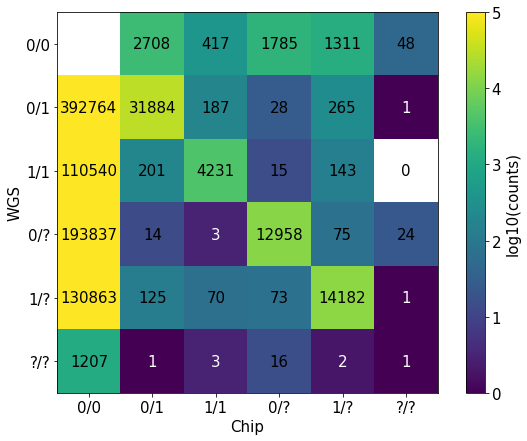

In [419]:
matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(10, 7))
plt.imshow(np.log10(confusion_no_00), vmin=0, vmax=5)
plt.xticks(range(6), ['0/0', '0/1', '1/1', '0/?', '1/?', '?/?'])
plt.yticks(range(6), ['0/0', '0/1', '1/1', '0/?', '1/?', '?/?'])
plt.xlabel('Chip')
plt.ylabel('WGS')
plt.colorbar(label='log10(counts)')

# Add the text
for y in range(6):
    for x in range(6):
        if x != 0 or y != 0:
            plt.text(x, y, confusion[y, x], color='black' if confusion[y, x] == 0 or confusion[y, x] > 10 else 'white', ha='center', va='center')

plt.show()

In [420]:
# confusion matrix
confusion_children = np.zeros((6, 6), dtype=int)
for opt1 in [-1, 0, 1, 2, 3, 4]:
    for opt2 in [-1, 0, 1, 2, 3, 4]:
        confusion_children[opt1, opt2] = np.sum((wgs_calls_children==opt1) & (chip_calls_children==opt2))

In [421]:
confusion_children_no_00 = confusion_children.copy()
confusion_children_no_00[0, 0] = 0

In [422]:
print(confusion_children)

[[1374324319      22430       1815         24        181          4]
 [    700283      57834       2549         54         78          0]
 [    160702       2297       5267          5         16          2]
 [      1329         40          7          1          0          0]
 [      6140        110         51          0          1          0]
 [       538          1          2          0          0          0]]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


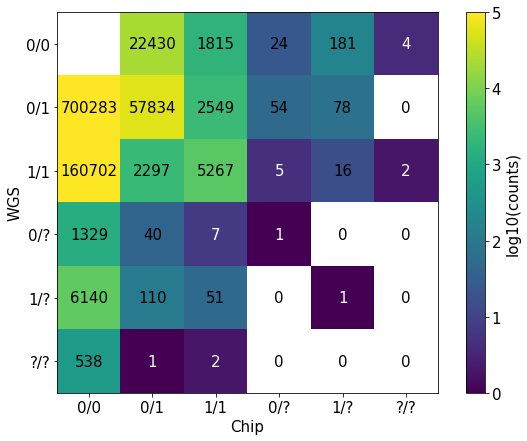

In [423]:
matplotlib.rcParams.update({'font.size': 15})

plt.figure(figsize=(10, 7))
plt.imshow(np.log10(confusion_children_no_00), vmin=0, vmax=5)
plt.xticks(range(6), ['0/0', '0/1', '1/1', '0/?', '1/?', '?/?'])
plt.yticks(range(6), ['0/0', '0/1', '1/1', '0/?', '1/?', '?/?'])
plt.xlabel('Chip')
plt.ylabel('WGS')
plt.colorbar(label='log10(counts)')

# Add the text
for y in range(6):
    for x in range(6):
        if x != 0 or y != 0:
            plt.text(x, y, confusion_children[y, x], color='black' if confusion_children[y, x] == 0 or confusion_children[y, x] > 10 else 'white', ha='center', va='center')

plt.show()

In [424]:
probes_per_wgs_del2 = defaultdict(int)
probes_per_chip_del2 = defaultdict(int)

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    del_pos = all_positions[i]
    pos_to_index = dict([(x, i) for i, x in enumerate(del_pos)])
    chip_pos_indices = np.array(sorted([pos_to_index[x] for c, x in sites if c==chrom]))
    chip_pos_array = np.zeros((len(del_pos),), dtype=bool)
    chip_pos_array[chip_pos_indices] = True
    
    # WGS
    in_del_wgs = (wgs_deletions[i][parent_indices, :]==1) | (wgs_deletions[i][parent_indices, :]==2) | (wgs_deletions[i][parent_indices, :]==4)
    in_del_chip = (chip_deletions[i][parent_indices, :]==1) | (chip_deletions[i][parent_indices, :]==2) | (chip_deletions[i][parent_indices, :]==4)

    del_start_x, del_start_y = np.where(~in_del_wgs[:, :-1] & in_del_wgs[:, 1:])
    del_end_x, del_end_y = np.where(in_del_wgs[:, :-1] & ~in_del_wgs[:, 1:])
    
    for start_x, start_y, end_x, end_y in zip(del_start_x, del_start_y, del_end_x, del_end_y):
        assert start_x == end_x
        probes = chip_pos_array[(start_y+1):(end_y+1)]
        num_probes = np.sum(probes)
        probes_per_wgs_del2[num_probes] += 1
        if (num_probes>0) and (np.sum(in_del_chip[start_x, np.where(probes)[0]+start_y+1]) >= num_probes/2):
            probes_per_chip_del2[num_probes] += 1
        
    # Chip
    #del_start_x, del_start_y = np.where(~in_del_chip[:, :-1] & in_del_chip[:, 1:])
    #del_end_x, del_end_y = np.where(in_del_chip[:, :-1] & ~in_del_chip[:, 1:])
    #
    #for start_x, start_y, end_x, end_y in zip(del_start_x, del_start_y, del_end_x, del_end_y):
    #    assert start_x == end_x
    #    probes_per_chip_del2[np.sum(chip_pos_array[(start_y+1):(end_y+1)])] += 1
    

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

In [425]:
print(max(probes_per_wgs_del2.keys()))

997


0.7624100375264439 0.0


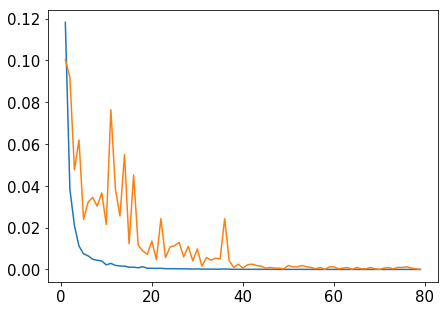

In [426]:
plt.figure(figsize=(7, 5))

wgs_norm = sum(probes_per_wgs_del2.values())
chip_norm = sum(probes_per_chip_del2.values())

print(probes_per_wgs_del2[0]/wgs_norm, probes_per_chip_del2[0]/chip_norm)
bins = range(1, 80)

plt.plot(bins, [probes_per_wgs_del2[x]/wgs_norm for x in bins])
plt.plot(bins, [probes_per_chip_del2[x]/chip_norm for x in bins])

plt.show()

In [427]:
# cf. 
# [1] R. G. Newcombe. Two-sided confidence intervals for the single proportion, 1998
# [2] R. G. Newcombe. Interval Estimation for the difference between independent proportions:        comparison of eleven methods, 1998

import numpy as np
from statsmodels.stats.proportion import proportion_confint

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
def propci_wilson_cc(count, nobs, alpha=0.05):
    # get confidence limits for proportion
    # using wilson score method w/ cont correction
    # i.e. Method 4 in Newcombe [1]; 
    # verified via Table 1
    from scipy import stats
    n = nobs
    p = count/n
    q = 1.-p
    z = stats.norm.isf(alpha / 2.)
    z2 = z**2   
    denom = 2*(n+z2)
    num = 2.*n*p+z2-1.-z*np.sqrt(z2-2-1./n+4*p*(n*q+1))    
    ci_l = num/denom
    num = 2.*n*p+z2+1.+z*np.sqrt(z2+2-1./n+4*p*(n*q-1))
    ci_u = num/denom
    if p == 0:
        ci_l = 0.
    elif p == 1:
        ci_u = 1.
    return ci_l, ci_u

997


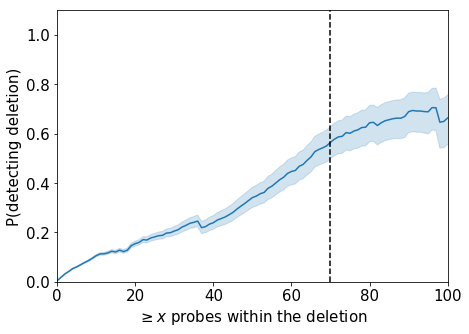

In [432]:
plt.figure(figsize=(7, 5))

maxvalue = max(probes_per_wgs_del2.keys())
print(maxvalue)
wgs_probecounts = np.array([probes_per_wgs_del2[x] for x in np.arange(maxvalue, -1, -1)])
chip_probecounts = np.array([probes_per_chip_del2[x] for x in np.arange(maxvalue, -1, -1)])

f = np.cumsum(chip_probecounts)/np.cumsum(wgs_probecounts)
e = [propci_wilson_cc(x, n) for x, n in zip(np.cumsum(chip_probecounts), np.cumsum(wgs_probecounts))]
p = plt.plot(np.arange(maxvalue, -1, -1), f)
plt.fill_between(np.arange(maxvalue, -1, -1), [x[0] for x in e], [x[1] for x in e], color=p[0].get_color(), alpha=0.2)

plt.xlim([0, 100])
plt.ylim([0, 1.1])
plt.xlabel('$\geq x$ probes within the deletion')
plt.ylabel('P(detecting deletion)')
plt.axvline(70, color='black', linestyle='--')
plt.show()



# Which probesets are best?

In [312]:
probes_per_wgs_chip = defaultdict(int)
probes_per_wgs_23andme = defaultdict(int)
probes_per_wgs_ancestry = defaultdict(int)
probes_per_wgs_23andme_ancestry = defaultdict(int)

for i, chrom in enumerate(chroms):
    print(chrom, end=' ')
    
    del_pos = all_positions[i]
    pos_to_index = dict([(x, i) for i, x in enumerate(del_pos)])
    
    pos_chip_indices = np.array(sorted([pos_to_index[x] for c, x in chip_positions_real if c==chrom]))
    pos_chip = np.zeros((len(del_pos),), dtype=bool)
    pos_chip[pos_chip_indices] = True
    
    pos_23andme_indices = np.array(sorted([pos_to_index[x] for c, x in chip_positions_23andme if c==chrom]))
    pos_23andme = np.zeros((len(del_pos),), dtype=bool)
    pos_23andme[pos_23andme_indices] = True
    
    pos_ancestry_indices = np.array(sorted([pos_to_index[x] for c, x in chip_positions_ancestry if c==chrom]))
    pos_ancestry = np.zeros((len(del_pos),), dtype=bool)
    pos_ancestry[pos_ancestry_indices] = True
    
    pos_23andme_ancestry_indices = np.array(sorted([pos_to_index[x] for c, x in chip_positions_23andme_ancestry if c==chrom]))
    pos_23andme_ancestry = np.zeros((len(del_pos),), dtype=bool)
    pos_23andme_ancestry[pos_23andme_ancestry_indices] = True
    
    # WGS
    in_del_wgs = (wgs_deletions[i][parent_indices, :]==1) | (wgs_deletions[i][parent_indices, :]==2) | (wgs_deletions[i][parent_indices, :]==4)
    del_start_x, del_start_y = np.where(~in_del_wgs[:, :-1] & in_del_wgs[:, 1:])
    del_end_x, del_end_y = np.where(in_del_wgs[:, :-1] & ~in_del_wgs[:, 1:])
    
    for start_x, start_y, end_x, end_y in zip(del_start_x, del_start_y, del_end_x, del_end_y):
        assert start_x == end_x
        probes_per_wgs_chip[np.sum(pos_chip[(start_y+1):(end_y+1)])] += 1
        probes_per_wgs_23andme[np.sum(pos_23andme[(start_y+1):(end_y+1)])] += 1
        probes_per_wgs_ancestry[np.sum(pos_ancestry[(start_y+1):(end_y+1)])] += 1
        probes_per_wgs_23andme_ancestry[np.sum(pos_23andme_ancestry[(start_y+1):(end_y+1)])] += 1
        
        
        
        

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 

No probes - inaccessible deletions
Chip 0.9324675749497064
23andme 0.7824700282952519
ancestry 0.9300142294041641
23andme + ancestry 0.7667195498928706


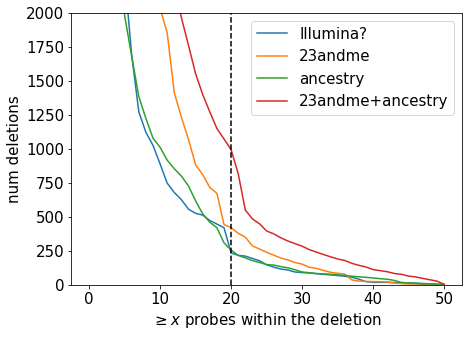

In [348]:
plt.figure(figsize=(7, 5))

print('No probes - inaccessible deletions')
print('Chip', probes_per_wgs_chip[0]/sum(probes_per_wgs_chip.values()))
print('23andme', probes_per_wgs_23andme[0]/sum(probes_per_wgs_23andme.values()))
print('ancestry', probes_per_wgs_ancestry[0]/sum(probes_per_wgs_ancestry.values()))
print('23andme + ancestry', probes_per_wgs_23andme_ancestry[0]/sum(probes_per_wgs_23andme_ancestry.values()))

bins = np.arange(50, -1, -1)

plt.plot(bins, np.cumsum(np.array([probes_per_wgs_chip[x] for x in bins])), label='Illumina?')
plt.plot(bins, np.cumsum(np.array([probes_per_wgs_23andme[x] for x in bins])), label='23andme')
plt.plot(bins, np.cumsum(np.array([probes_per_wgs_ancestry[x] for x in bins])), label='ancestry')
plt.plot(bins, np.cumsum(np.array([probes_per_wgs_23andme_ancestry[x] for x in bins])), label='23andme+ancestry')

plt.ylim([0, 2000])
plt.axvline(20, color='black', linestyle='--')
plt.xlabel('$\geq x$ probes within the deletion')
plt.ylabel('num deletions')
plt.legend()
plt.show()

In [331]:
print(np.sum(f*np.cumsum(np.array([probes_per_wgs_chip[x] for x in np.arange(maxvalue, -1, -1)]))))
print(np.sum(list(probes_per_wgs_chip.values())))


10800.0
244564


In [439]:
print(len(chip_positions_real), len([x for x in chip_positions_real if x[0] not in chroms]))
print(len(chip_positions_ancestry), len([x for x in chip_positions_ancestry if x[0] not in chroms]))
print(len(chip_positions_23andme), len([x for x in chip_positions_23andme if x[0] not in chroms]))


546840 15428
701478 18929
638531 24564
